### CSCN8010 - Foundations of Machine Learning
### Final Project
### Group No. : 23
### Team Members:
  - Rohit Laxmandas Totlani
  - Ayush Patel
  

___

## Brain Tumor Detection

Problem Statement: Brain tumors are a serious health problem that can be difficult to detect early. Early detection is crucial for successful treatment, but current methods are often time-consuming and inaccurate.​
​


Motivation: Our project aims to develop a deep learning model that can accurately detect brain tumors from MRI images. This model could help doctors diagnose brain tumors earlier and more accurately, leading to better patient outcomes.​
​


Objective: The objective of this project is to develop a deep learning model that can accurately classify brain tumor images with an accuracy of at least 90%.​


### Importing Libraries

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
from collections import Counter
import kagglehub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import shutil
import tensorflow as tf
import numpy as np
import requests
from io import BytesIO
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications import ResNet50

<br>

### Downloading Data

In [2]:
# Download latest version to /kaggle/input
path = kagglehub.dataset_download("tombackert/brain-tumor-mri-data")

print("Path to dataset files:", path)

100%|██████████| 151M/151M [00:07<00:00, 20.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tombackert/brain-tumor-mri-data/versions/1


<br>

### EDA - Exploratory Data Analysis

In [3]:
# Dataset path
dataset_path = '/root/.cache/kagglehub/datasets/tombackert/brain-tumor-mri-data/versions/1/brain-tumor-mri-dataset'

# Subfolder (class) names
categories = os.listdir(dataset_path)
print("Classes in the dataset:", categories)

Classes in the dataset: ['meningioma', 'pituitary', 'glioma', 'notumor']


<b>

Number of images in each class: {'meningioma': 1775, 'pituitary': 1757, 'glioma': 1621, 'notumor': 2000} 




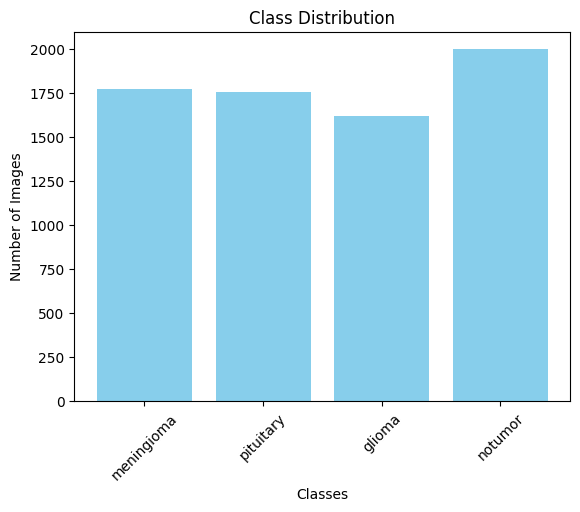

In [4]:
# Count number of images in each class
image_counts = {
    category: len(os.listdir(os.path.join(dataset_path, category)))
    for category in categories
    if os.path.isdir(os.path.join(dataset_path, category))  # Check if it's a directory
}

print("Number of images in each class:", image_counts, "\n\n")

# Plot class distribution
plt.bar(image_counts.keys(), image_counts.values(), color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

<br>

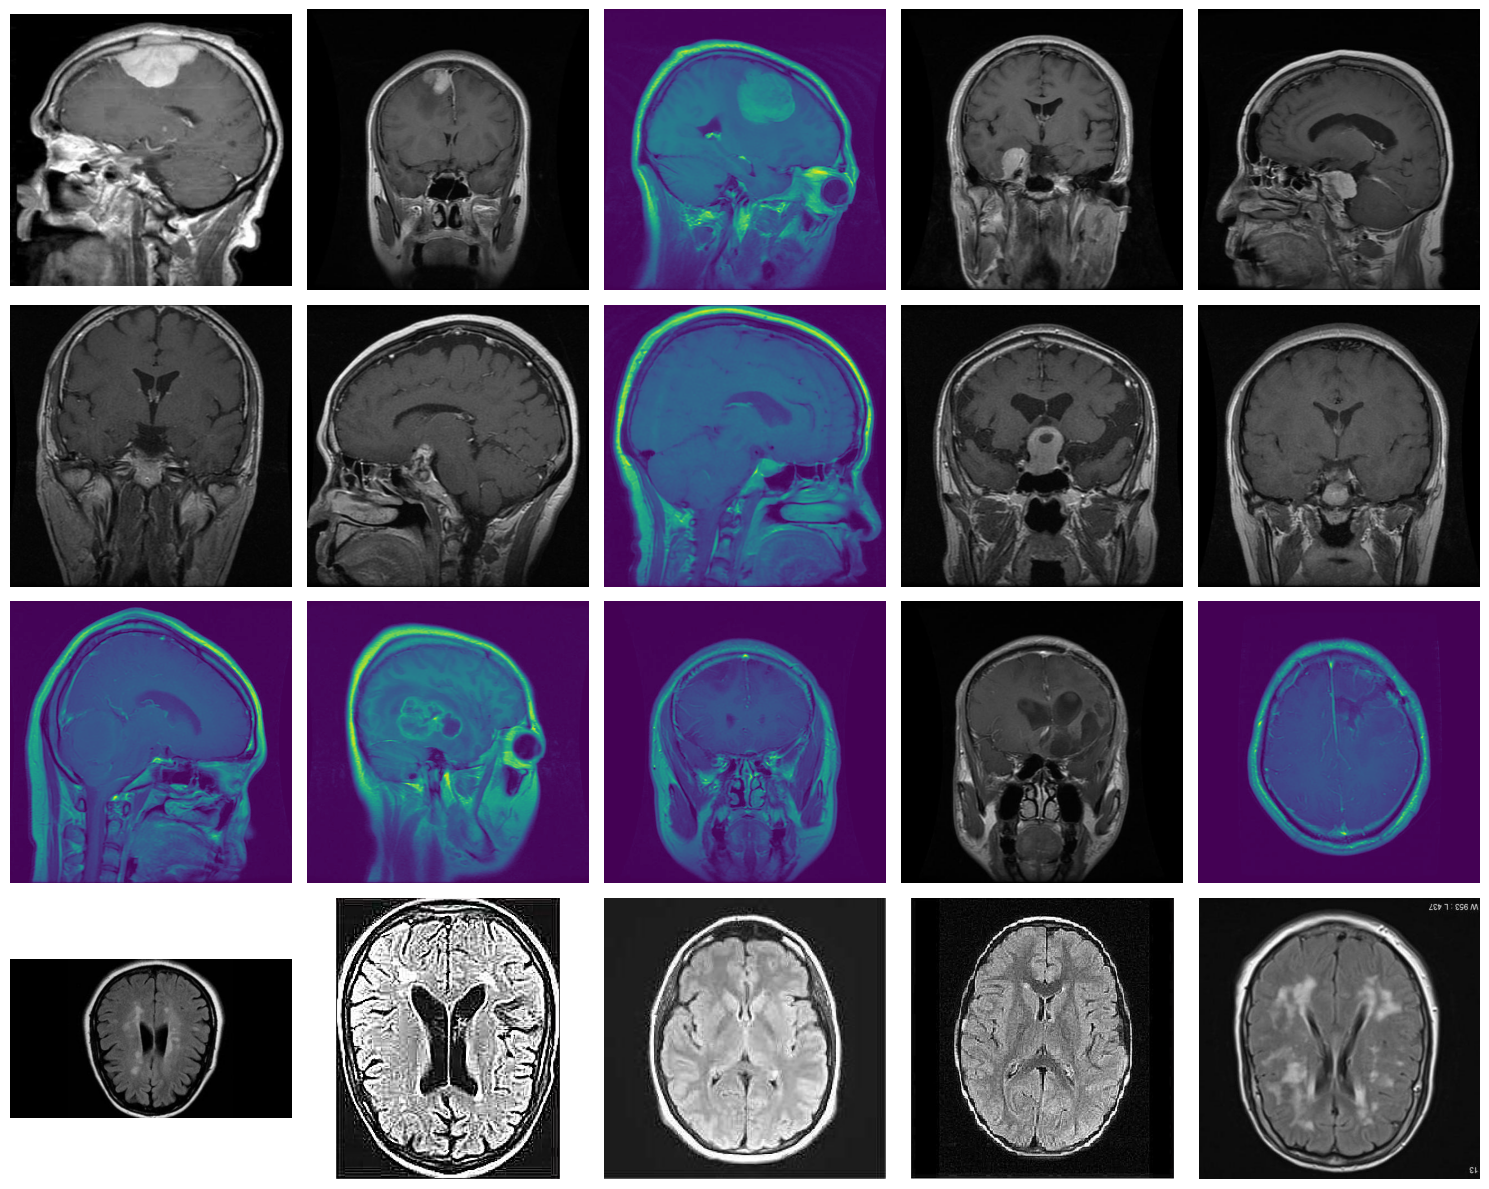

In [5]:
# Display 5 random images from each category
def display_sample_images(dataset_path, categories, num_samples=5):
    plt.figure(figsize=(15, len(categories) * 3))
    for i, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        if not os.path.isdir(category_path):  # Skip non-directory entries
            continue
        images = random.sample(os.listdir(category_path), num_samples)
        for j, img_name in enumerate(images):
            img_path = os.path.join(category_path, img_name)
            img = Image.open(img_path)
            plt.subplot(len(categories), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.axis('off')
            if j == 0:
                plt.ylabel(category, fontsize=14)
    plt.tight_layout()
    plt.show()

# Call the function
categories = [cat for cat in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, cat))]
display_sample_images(dataset_path, categories, num_samples=5)

<br>

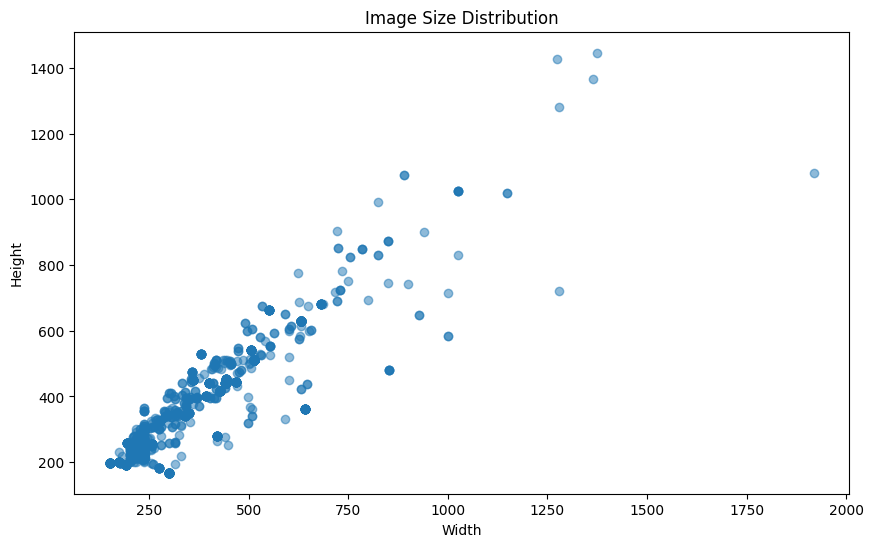

Most common image size: ((512, 512), 4859)


In [6]:
# Analyze image sizes
image_sizes = []
for category in categories:
    category_path = os.path.join(dataset_path, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        with Image.open(img_path) as img:
            image_sizes.append(img.size)

# Plot distribution of image sizes
widths, heights = zip(*image_sizes)
plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, alpha=0.5)
plt.title('Image Size Distribution')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

print(f"Most common image size: {Counter(image_sizes).most_common(1)[0]}")

<br>

### Data Preprocessing

In [7]:
# Check for duplicate images
image_hashes = set()
duplicate_count = 0

for category in categories:
    category_path = os.path.join(dataset_path, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        with Image.open(img_path) as img:
            img_hash = hash(img.tobytes())  # Hash of image data
            if img_hash in image_hashes:
                duplicate_count += 1
            else:
                image_hashes.add(img_hash)

print(f"Number of duplicate images: {duplicate_count}")

Number of duplicate images: 556


<br>

In [8]:
# Path to dataset
dataset_path = '/root/.cache/kagglehub/datasets/tombackert/brain-tumor-mri-data/versions/1/brain-tumor-mri-dataset'

# Create a backup folder for duplicates
duplicates_backup_path = '/root/.cache/kagglehub/datasets/tombackert/brain-tumor-mri-data/versions/1/duplicates_backup'
os.makedirs(duplicates_backup_path, exist_ok=True)

# Identify and remove duplicates
image_hashes = set()
duplicate_count = 0

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if not os.path.isdir(category_path):  # Skip non-directories
        continue
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        try:
            with Image.open(img_path) as img:
                img_hash = hash(img.tobytes())  # Generate hash of the image
                if img_hash in image_hashes:
                    # Move duplicate to backup folder
                    duplicate_count += 1
                    duplicate_backup_path = os.path.join(duplicates_backup_path, img_name)
                    os.rename(img_path, duplicate_backup_path)
                else:
                    image_hashes.add(img_hash)
        except Exception as e:
            print(f"Error processing file {img_path}: {e}")

print(f"Number of duplicates removed: {duplicate_count}")

Number of duplicates removed: 556


<br>

### Data Splitting into Train and Test

In [9]:
# Path to the cleaned dataset
dataset_path = '/root/.cache/kagglehub/datasets/tombackert/brain-tumor-mri-data/versions/1/brain-tumor-mri-dataset'

# Paths for train and test datasets
train_path = '/root/.cache/kagglehub/datasets/tombackert/brain-tumor-mri-data/versions/1/train'
test_path = '/root/.cache/kagglehub/datasets/tombackert/brain-tumor-mri-data/versions/1/test'

# Create directories for train and test datasets
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Train-test split ratio
split_ratio = 0.8

# Split data
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if not os.path.isdir(category_path):  # Skip non-directory files
        continue

    # Create category folders in train and test directories
    train_category_path = os.path.join(train_path, category)
    test_category_path = os.path.join(test_path, category)
    os.makedirs(train_category_path, exist_ok=True)
    os.makedirs(test_category_path, exist_ok=True)

    # List all images in the category
    images = os.listdir(category_path)
    random.shuffle(images)  # Shuffle images for random splitting

    # Split images into train and test
    split_index = int(len(images) * split_ratio)
    train_images = images[:split_index]
    test_images = images[split_index:]

    # Move images to respective directories
    for img_name in train_images:
        shutil.copy(os.path.join(category_path, img_name), os.path.join(train_category_path, img_name))
    for img_name in test_images:
        shutil.copy(os.path.join(category_path, img_name), os.path.join(test_category_path, img_name))

print("Dataset has been split into train and test sets.")

Dataset has been split into train and test sets.


<br>

### CNN

In [10]:
import tensorflow as tf

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='int',
    batch_size=16,
    image_size=(128, 128),
    shuffle=True
)

Found 5276 files belonging to 4 classes.


In [11]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    labels='inferred',
    label_mode='int',
    batch_size=16,
    image_size=(128, 128),
    shuffle=True
)

Found 1321 files belonging to 4 classes.


In [13]:
names = train_ds.class_names
num_classes = len(names)

print(names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
model = tf.keras.Sequential([
    layers.Input(shape=[128, 128, 3]),
    layers.Rescaling(1./255),

    # Data augmentation layers
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),

    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(num_classes, activation='softmax')  # Use softmax for multi-class classification
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,097,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,121,380 (8.09 MB)

 Trainable params: 2,121,380 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(
    train_ds,
    epochs=15
)

Epoch 1/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.5625 - loss: 0.9761
Epoch 2/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7639 - loss: 0.5987
Epoch 3/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7931 - loss: 0.5181
Epoch 4/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8257 - loss: 0.4414
Epoch 5/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8260 - loss: 0.4440
Epoch 6/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8574 - loss: 0.3755
Epoch 7/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8633 - loss: 0.3303
Epoch 8/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8810 - loss: 0.3072
Epoch 9/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8952 - loss: 0.3033
Epoch 10/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8925 - loss: 0.2864
Epoch 11/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8914 - loss: 0.2707
Epoch 12/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms

In [18]:
loss, acc = model.evaluate(test_ds)

print(f"Test Accuracy: {acc * 100:.2f}%")

83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9136 - loss: 0.2721
Test Accuracy: 91.07%


In [32]:
from sklearn.metrics import classification_report
import numpy as np

# Function to generate classification report
def print_classification_report(model, test_ds):
    true_labels = []
    pred_labels = []

    # Iterate over the test dataset to collect true labels and predictions
    for images, labels in test_ds:
        true_labels.extend(labels.numpy())  # True labels
        preds = model.predict(images, verbose = 0)  # Model predictions
        pred_labels.extend(np.argmax(preds, axis=1))  # Get the class with the highest probability

    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)

    # Generate classification report
    report = classification_report(true_labels, pred_labels)
    print(report)

# Print the classification report for your model
print_classification_report(model, test_ds)

              precision    recall  f1-score   support

           0       0.82      0.96      0.88       324
           1       0.94      0.71      0.81       307
           2       0.97      0.98      0.97       342
           3       0.93      0.98      0.95       348

    accuracy                           0.91      1321
   macro avg       0.91      0.91      0.90      1321
weighted avg       0.92      0.91      0.91      1321



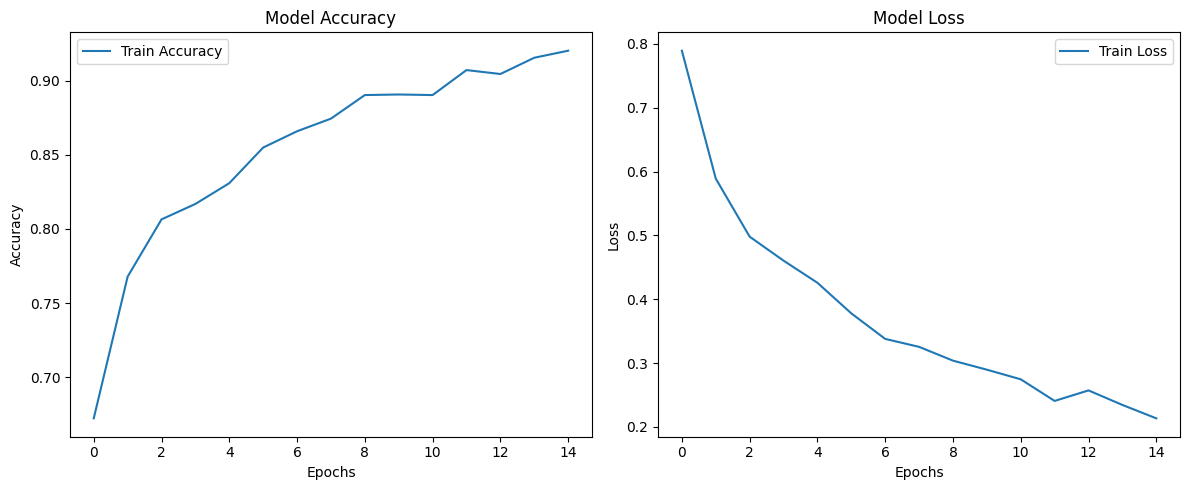

In [41]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [43]:
class_names = ["Glioma", "Meningioma", "No Tumor", "Pituitary"]

# Function to download an image from a URL
def download_image(image_url, target_size):
    try:
        response = requests.get(image_url)
        response.raise_for_status()

        # Open the image and convert it to RGB
        image = Image.open(BytesIO(response.content)).convert("RGB")

        # Resize the image to match the model's input size
        image = image.resize(target_size)

        # Convert the image to a NumPy array
        image_array = np.array(image)

        # Add batch dimension for prediction
        image_array = np.expand_dims(image_array, axis=0)

        return image_array
    except Exception as e:
        print(f"Error downloading or processing the image: {e}")
        return None


# Function to predict on an image
def predict_from_url(model, image_url, target_size):
    # Download the image
    image_array = download_image(image_url, target_size)

    if image_array is not None:
        # Run the model prediction
        predictions = model.predict(image_array)

        # Apply softmax to logits to get probabilities
        probabilities = tf.nn.softmax(predictions).numpy()

        # Print the probabilities for each class
        print("Prediction Probabilities:", probabilities)

        # Assuming a classification model, get the class with highest probability
        predicted_class = np.argmax(predictions, axis=1)[0]

        # Get the class name from the model's class names
        predicted_class_name = class_names[predicted_class]

        print(f"Predicted Class Index: {predicted_class}, Predicted Class Name: {predicted_class_name}")
        return predicted_class_name
    else:
        print("Prediction failed due to image download error.")


target_size = (128, 128)
image_url = "https://prod-images-static.radiopaedia.org/images/13656005/bd937738ad6223a03f8aedcf4920a7_big_gallery.jpeg"

predict_from_url(model, image_url, target_size)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Prediction Probabilities: [[0.17488714 0.17487988 0.47535303 0.17487988]]
Predicted Class Index: 2, Predicted Class Name: No Tumor


'No Tumor'

<br>



---



### ResNet50

In [20]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
resnet.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [21]:
modelResnet = Sequential([
    resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [22]:
modelResnet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
modelResnet.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [24]:
historyResnet = modelResnet.fit(
    train_ds,
    epochs=15
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


330/330 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.7370 - loss: 0.7789
Epoch 2/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.9037 - loss: 0.2452
Epoch 3/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9298 - loss: 0.1984
Epoch 4/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9531 - loss: 0.1301
Epoch 5/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9660 - loss: 0.0976
Epoch 6/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9579 - loss: 0.1093
Epoch 7/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9776 - loss: 0.0608
Epoch 8/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9734 - loss: 0.0686
Epoch 9/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9786 - loss: 0.0568
Epoch 10/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9870 - loss: 0.0350
Epoch 11/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9904 - loss: 0.0311
Epoch 12/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms

In [25]:
loss, acc = modelResnet.evaluate(test_ds)

print(f"Test Accuracy: {acc * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9384 - loss: 0.2365
Test Accuracy: 93.79%


In [33]:
from sklearn.metrics import classification_report
import numpy as np

# Function to generate classification report
def print_classification_report(model, test_ds):
    true_labels = []
    pred_labels = []

    # Iterate over the test dataset to collect true labels and predictions
    for images, labels in test_ds:
        true_labels.extend(labels.numpy())  # True labels
        preds = model.predict(images, verbose = 0)  # Model predictions
        pred_labels.extend(np.argmax(preds, axis=1))  # Get the class with the highest probability

    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)

    # Generate classification report
    report = classification_report(true_labels, pred_labels)
    print(report)

# Print the classification report for your model
print_classification_report(modelResnet, test_ds)


              precision    recall  f1-score   support

           0       0.95      0.90      0.92       324
           1       0.87      0.91      0.89       307
           2       0.96      0.99      0.97       342
           3       0.97      0.95      0.96       348

    accuracy                           0.94      1321
   macro avg       0.94      0.94      0.94      1321
weighted avg       0.94      0.94      0.94      1321



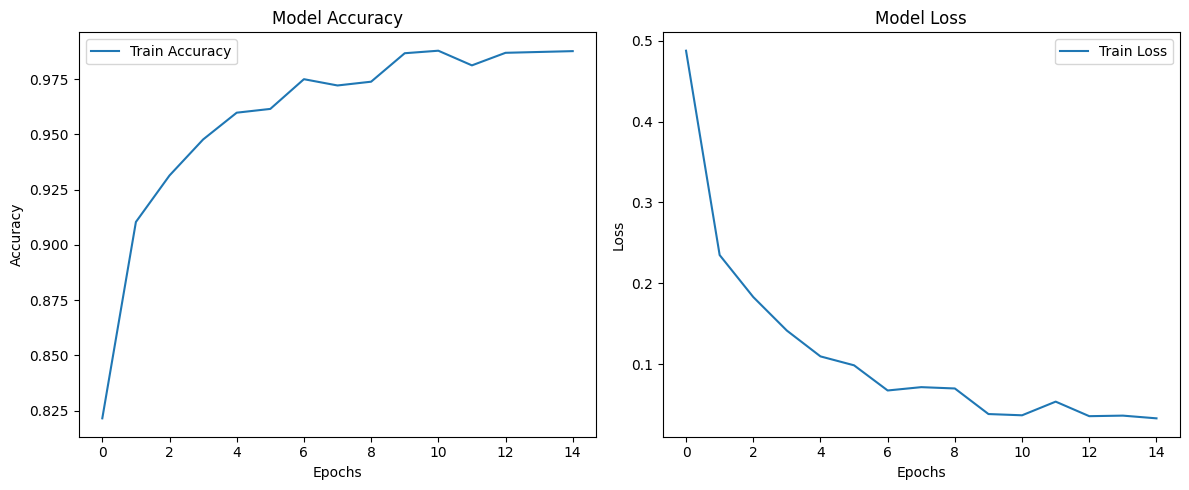

In [42]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(historyResnet.history['accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(historyResnet.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

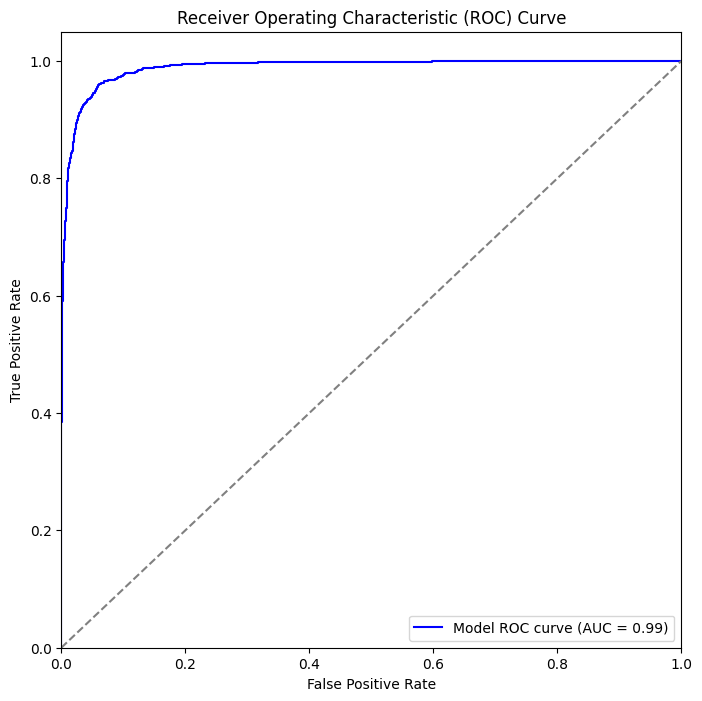

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical

# Function to compute ROC and AUC
def plot_roc_curve(model, test_ds, num_classes):
    # Get true labels and predicted probabilities
    true_labels = []
    pred_probs = []

    for images, labels in test_ds:
        true_labels.extend(labels.numpy())  # True labels (from the dataset)
        preds = model.predict(images, verbose=0)  # Model predictions
        pred_probs.extend(preds)  # Predicted probabilities for each class

    # Convert to numpy arrays
    true_labels = np.array(true_labels)
    pred_probs = np.array(pred_probs)

    # Binarize the true labels (multi-class to one-hot encoding)
    true_labels_one_hot = to_categorical(true_labels, num_classes)

    # Compute ROC curve and AUC for each class
    fpr, tpr, thresholds = roc_curve(true_labels_one_hot.ravel(), pred_probs.ravel())
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='b', label=f'Model ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (chance level)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC curve for your model
plot_roc_curve(model, test_ds, num_classes)


<br>

### Conclusion

The CNN and ResNet50 models were used for classifying brain tumors into four categories: glioma, meningioma, notumor, and pituitary. The CNN model achieved an accuracy of 91.07%, while ResNet50 outperformed it with an accuracy of 93.79%. Both models demonstrated strong performance, with ResNet50 achieving higher precision and recall across all tumor types. The models proved effective in detecting and classifying brain tumors, with potential for further improvements through optimizations.